### Keypoints Extraction using Mediapipe

#### Importing the Dependencies

In [136]:
import mediapipe as mp
import os
import json
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

#### Mediapipe Keypoints
1.  Pose: Total of 6 landmarks
2. Hands: Total of 42 landmarks
3. Face: Total of 478 landmarks, but we will use only 132 of them focusing on lips, eyes, eyebrows, and face outline
##### Total of 180 landmarks having (x, y, z) coordinates

In [44]:
##Defining the landmarks length
hands_landmarks = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

hands_num = len(hands_landmarks)
pose_num = len(filtered_pose)
face_num = len(filtered_face)

In [45]:
print(hands_num, face_num, pose_num)

21 132 6


#### Extracting Landmarks

In [109]:
##Defning Mediapipe objects
hands = mp.solutions.hands.Hands()
face = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)
pose = mp.solutions.pose.Pose()

In [110]:
print(hands)
print(face)
print(pose)

In [18]:
##Creating a 3D numpy array to store all the landmarks of Hands, Face and Pose
all_landmarks = np.zeros((hands_num * 2 + pose_num + face_num, 3))

In [19]:
all_landmarks[hands_num:hands_num * 2, :]  ##in this the the starting row index in hands_num that is 21 and ending row index is hands_num * 2 that is 42. 
##And : represents the columns indexing, : means all the columns.
##That is all 21 landmarks from one hand will be stored in all_landmarks[21:42, :], and in all the column that is the coordinates of the landmarks (x, y, z).
##These will be stored starting from 21st row to the 42nd row with all the three coordinates as columns.

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [111]:
## Extracting Landmarks from a frame
def get_landmarks_from_frame(frame):
    
    ##Creating a 3D numpy array to store all the landmarks of Hands, Face and Pose
    all_landmarks = np.zeros((hands_num * 2 + pose_num + face_num, 3))
    
    ##Getting the hands landmarks
    def get_hands(frame):
        results_hands = hands.process(frame)
        
        ##If results contains the landmarks
        if results_hands.multi_hand_landmarks:
            
            ##Storing the all_landmakrs array
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0:
                    ##Storing in the first 21 rows
                    all_landmarks[:hands_num, :] = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])  ## Right Hand
                    
                else:
                    all_landmarks[hands_num:hands_num * 2, :] = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])  ## Left Hand
                    
    ##Getting the pose landmarks
    def get_pose(frame):
        results_pose = pose.process(frame)
        
        ##If landmarks exists
        if results_pose.pose_landmarks:
            all_landmarks[hands_num * 2: hands_num * 2 + pose_num, :] = np.array([(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
            
    ##Getting the face landmarks
    def get_face(frame):
        results_face = face.process(frame)
        
        ##If landmarks exists
        if results_face.multi_face_landmarks:
            all_landmarks[hands_num * 2 + pose_num:, :] = np.array([(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
            
    
    ##Executing these three functions simultaneously using threading
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)
        
        
    return all_landmarks

In [77]:
frame = "Data\spreadthesign - VLC media player 28-08-2024 13_15_36.png"
frame = cv2.imread(frame)
landmarks = get_landmarks_from_frame(frame)

In [78]:
landmarks

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [112]:
## Extracting Landmarks from a Video
def get_landmarks_from_video(video_path, start_frame = 1, end_frame = -1):
    
    ##Capturing the Video
    cap = cv2.VideoCapture(video_path)
    
    ##If the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    ##If the video is Pre-Cropped
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    ##If the ending of the video is not given
    if end_frame < 1:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    ##Total number of Landmarks
    num_landmarks = hands_num * 2 + pose_num + face_num
    
    ##All Frames Landmarks
    all_frames_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    
    frame_index = 1
    
    ##Reading through the Video
    ##If cap is opened and the frame index is less than the end frame
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        ##If Frame Index is greater than or equal to the Start Frame
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            landmarks = get_landmarks_from_frame(frame)
            
            all_frames_landmarks[frame_index - start_frame] = landmarks
            
        frame_index += 1
        
    cap.release()
    hands.reset()
    pose.reset()
    face.reset()
    
    return all_frames_landmarks

In [126]:
##Drawing Landmarks
def draw_landmarks(input_path, output_path, video_landmarks, start_frame = 1, end_frame = -1):
    
    cap = cv2.VideoCapture(input_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

#### Visualizing Landmarks

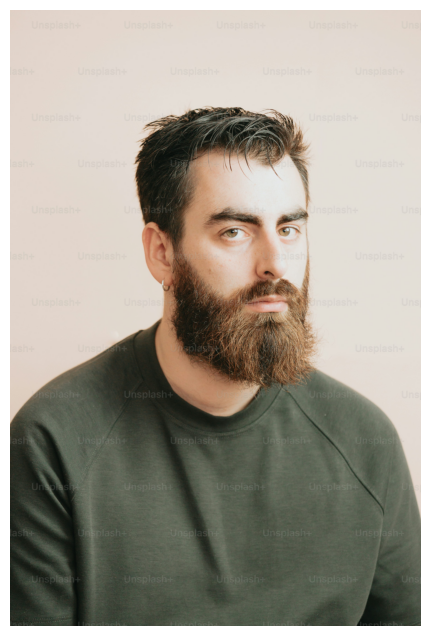

In [127]:
##Visualizing on an Image
image_url = 'https://plus.unsplash.com/premium_photo-1664536392896-cd1743f9c02c?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29ufGVufDB8fDB8fHww'
response = requests.get(image_url)

##Reading as bytes from response
img = Image.open(BytesIO(response.content))

##Converting into numpy array from the Image object to perform cv2 Operations
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

c:\Users\Eren Jaeger\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+

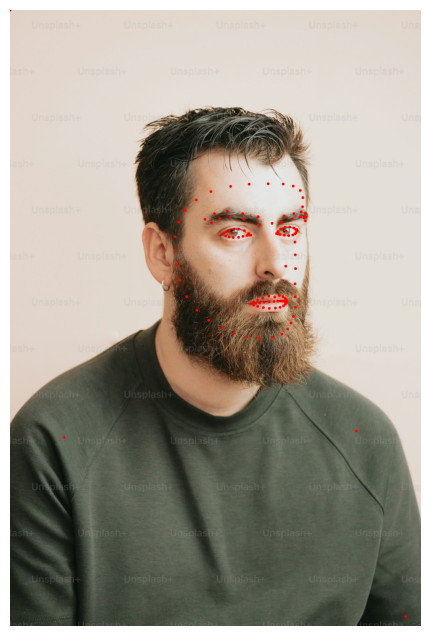

In [128]:
##Visuzlizing landmarks
height, width, _ = img.shape

frame_landmarks = get_landmarks_from_frame(img[:, :, ::-1])
print(frame_landmarks)

for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    
    cv2.circle(img, (x, y), 10, (0, 0, 255), -1)
    

plt.figure(figsize=(8, 8))
plt.imshow(img[:, :, ::-1])
plt.axis("off")
plt.show()

In [130]:
##Visualizing on a video

##Opening our Reorganized Data 
with open("Reorganized_Data.json", "r") as json_file:
    all_data = json.load(json_file)
    
test = all_data[42]
print(test)

video_landmarks = get_landmarks_from_video(test["video_path"], test["frame_start"], test["frame_end"])

output_path = "data/output_video_test_40.mp4"

draw_landmarks(test["video_path"], output_path, video_landmarks, test["frame_start"], test["frame_end"])

{'frame_start': 1, 'frame_end': -1, 'split': 'train', 'video_path': 'Data/videos\\05732.mp4', 'gloss': 'before'}


#### Data Encoding and Saving

In [131]:
##Directory to save the landmarks Data
npy_directory = "Data\landmarks"

In [ ]:
##Encoding and saving the features
try:
    for i in tqdm(range(len(all_data)), ncols=100):
        
        ##Saving in npy format
        ##Defining the path
        npy_path = os.path.join(npy_directory, f"{i}.npy")
        
        if os.path.exists(npy_path):
            continue
        
        video_path = all_data[i]["video_path"]
        start_frame = all_data[i]["frame_start"]
        end_frame = all_data[i]["frame_end"]
        
        try:
            ##Extracting Landmarks from the Video
            video_frames_landmarks = get_landmarks_from_video(video_path, start_frame, end_frame)
            
            ##Saving the Landmarks
            np.save(npy_path, video_frames_landmarks)
            
        except Exception as e:
            print(f"Error during extraction from {i}: ", e)
            continue
        
        clear_output(wait=True)
        
except Exception as e:
    print("Can not Continue")
            

In [ ]:
## Saving the numpy arrays based on the word/gloss for that video instance in the Data.
## Creating a subfolder for all the words/gloss and saving the landmarks into the the subfolder of the word that video is referring to.